# OVI detection relationship with impact factor

In this notebook we explore whether there is a relationship between the detection of OVI in the galaxy groups, and the projected separation at the group redshift (impact factor) from the quasar from which the absorption features were measured. We also constrast the differences between using our measurements of position and scale radius, and using the positions and radii derived by Stocke et al. 2019 from optical spectra.

## Import Statements

In [58]:
import pandas as pd
from astropy.units import Quantity
import numpy as np
from matplotlib import pyplot as plt

from xga.utils import DEFAULT_COSMO
from xga.sourcetools.misc import ang_to_rad
from xga.utils import r500 as r500_unit
from xga.utils import r2500 as r2500_unit

## Defining useful functions

Here we define any functions that are to be used in this notebook:

In [27]:
# This calculates the separation between two RA-DEC points
def hav_sep(ra, dec, ra2, dec2):
    hav_sep = 2 * np.arcsin(np.sqrt((np.sin(((dec2*(np.pi / 180))-(dec*(np.pi / 180))) / 2) ** 2)
                                    + np.cos((dec * (np.pi / 180))) * np.cos(dec2 * (np.pi / 180))
                                    * np.sin(((ra2*(np.pi / 180)) - (ra*(np.pi / 180))) / 2) ** 2))
    # Converting back to degrees from radians
    hav_sep /= (np.pi / 180)
    return Quantity(hav_sep, 'deg')

## Loading data tables

We have to load several data tables to get the information for this notebook. We start by reading in the information on the quasars that were used to measure the line of sight absorption features. This is primarily to retrieve their name and position; the name will be used to match to the relevant group(s), and the position is used to calculate the impact factor:

In [22]:
quas = pd.read_csv('../../sample_files/quasar_info.csv')
quas = quas.rename(columns={'name': 'quasar_name', 'ra': 'quas_ra', 'dec': 'quas_dec', 
                            'redshift': 'quas_redshift'})
quas

,quasar_name,quas_ra,quas_dec,quas_redshift
0,B1612+266,243.544,26.547,0.395
1,FBQS1519+2838,229.901,28.641,0.270
2,SBS0956+509,149.882,50.747,0.143
3,RBS711,129.245,44.434,0.255
4,FBQSJ1030+3102,157.746,31.049,0.178
5,PHL1811,328.756,-9.373,0.201


This file contains the adopted optical central positions, and optically determined radii used by Stocke et al. - they will be used to contrast the results attained through the use of X-ray derived properties:

In [12]:
opt_groups = pd.read_csv("../../sample_files/opt_group_info.csv")
opt_groups

,name,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,ov_obs_ad,r_obs_ad,quasar
0,25124,243.541,0.018,26.625,0.036,0.186,448.0,1167.0,B1612+266
1,44739,229.811,0.033,28.413,0.051,0.118,336.0,1135.0,FBQS1519+2838
2,19670A,150.196,0.044,50.794,0.028,0.134,404.0,991.0,SBS0956+509
3,19670B,150.196,0.044,50.794,0.028,0.134,404.0,991.0,SBS0956+509
4,12833,129.423,0.040,44.295,0.029,0.145,444.0,1396.0,RBS711
5,44858,230.091,0.027,28.850,0.013,0.127,569.0,1546.0,FBQS1519+2838
6,PHL1811,NaN,NaN,NaN,NaN,0.077,NaN,NaN,PHL1811
7,50433,157.742,0.026,30.864,0.009,0.136,338.0,600.0,FBQSJ1030+3102


<font color='red'>Why did I bother measuring three different ways if we're only using one??</font>

Finally, we read in the data tables containing X-ray properties:

In [16]:
xray_prop = pd.read_csv("../../outputs/results/ltr_r500_pipeline_results.csv")
# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop = xray_prop.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})
del xray_prop['redshift']
xray_prop

,name,xray_ra,xray_dec,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,...,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124,243.629055,26.730240,894.328175,4.09508,0.336509,0.428803,7.160965e+43,1.654052e+42,1.409422e+42,...,1.248581e+43,4.089550,0.541060,0.776698,4.365940e+43,1.182220e+42,1.034055e+42,1.295826e+44,1.153971e+43,1.158880e+43
1,44739,229.793620,28.331750,420.327709,1.01750,0.070825,0.086338,2.087752e+42,2.763224e+41,3.007630e+41,...,4.755757e+41,0.997597,0.086556,0.089026,1.703969e+42,2.508437e+41,1.974190e+41,2.946334e+42,2.406044e+41,5.992094e+41
2,19670A,150.256710,50.793942,471.746417,1.19978,0.119322,0.137150,1.473682e+42,2.794262e+41,2.535198e+41,...,7.943540e+41,1.278810,0.143419,0.158449,1.122548e+42,3.063895e+41,2.630961e+41,2.168193e+42,2.788445e+41,8.557280e+41
3,19670B,150.214920,50.805014,535.987637,1.57037,0.163560,0.225675,3.781171e+42,4.659777e+41,4.080644e+41,...,1.212557e+42,1.540700,0.177902,0.232237,3.274214e+42,3.825586e+41,2.633952e+41,6.766424e+42,7.349113e+41,1.161753e+42
4,12833,129.496800,44.248700,491.088940,1.37449,0.091825,0.103582,3.462101e+42,3.938930e+41,4.176430e+41,...,9.162024e+41,1.412940,0.131396,0.193668,2.240856e+42,2.757205e+41,3.609433e+41,4.495442e+42,8.299008e+41,7.554535e+41
5,44858,230.112000,28.887750,621.787069,2.07963,0.127336,0.173356,2.181280e+43,9.676633e+41,9.866408e+41,...,3.430648e+42,1.974800,0.137603,0.181453,1.546781e+43,9.979022e+41,6.827373e+41,3.457737e+43,2.669997e+42,2.986686e+42
6,PHL1811,328.769920,-9.588805,567.682822,1.66376,0.063290,0.063418,7.779805e+42,4.102416e+41,4.214600e+41,...,1.015352e+42,1.667990,0.090055,0.104340,5.006875e+42,3.197985e+41,2.995331e+41,1.125824e+43,9.642434e+41,1.137265e+42
7,50433,157.758000,30.862000,476.228525,1.26351,0.083351,0.094711,2.471845e+42,5.537633e+41,4.281101e+41,...,9.199127e+41,1.282590,0.111653,0.135354,1.759042e+42,4.224844e+41,3.402023e+41,3.404955e+42,5.223562e+41,1.094591e+42


In [42]:
xray_prop_r2500 = pd.read_csv("../../outputs/results/ltr_r2500_pipeline_results.csv")
# This makes the merging below a bit neater - means there are no column name clashes, everything is clear, and 
#  we don't duplicate information this is already in another DF (the redshift)
xray_prop_r2500 = xray_prop_r2500.rename(columns={'ra': 'xray_ra', 'dec': 'xray_dec'})
del xray_prop_r2500['redshift']
del xray_prop_r2500['xray_ra']
del xray_prop_r2500['xray_dec']
xray_prop_r2500

,name,r2500,Tx2500,Tx2500-,Tx2500+,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+
0,25124,362.843666,3.43802,0.245831,0.285847,4.880076e+43,6.840523e+41,1.057330e+42,1.338002e+44,5.156634e+42,5.166021e+42
1,44739,207.700972,1.18108,0.192817,0.454015,4.979938e+41,9.800368e+40,1.654720e+41,9.302423e+41,2.993975e+41,3.193630e+41
2,19670A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19670B,285.371536,2.51940,0.468937,0.865252,1.933181e+42,1.581095e+41,2.578137e+41,4.687436e+42,7.281363e+41,8.204501e+41
4,12833,219.740422,1.39687,0.088530,0.108408,2.196352e+42,2.319379e+41,2.373033e+41,4.388141e+42,2.887082e+41,5.121473e+41
5,44858,291.977743,2.21005,0.169979,0.209562,1.226591e+43,4.958002e+41,6.772869e+41,2.843935e+43,1.529736e+42,1.742099e+42
6,PHL1811,256.960286,1.68109,0.066696,0.075367,5.479201e+42,3.716317e+41,2.100032e+41,1.234751e+43,6.693423e+41,8.047603e+41
7,50433,199.073857,1.11745,0.101489,0.118951,1.708593e+42,2.075795e+41,1.713427e+41,3.111598e+42,3.945652e+41,3.717549e+41


In [43]:
comb = pd.merge(quas, opt_groups, left_on='quasar_name', right_on='quasar', how='outer')
comb = pd.merge(comb, xray_prop, left_on='name', right_on='name')
comb = pd.merge(comb, xray_prop_r2500, left_on='name', right_on='name')
comb

,quasar_name,quas_ra,quas_dec,quas_redshift,name,opt_ra,opt_ra_err,opt_dec,opt_dec_err,redshift,...,r2500,Tx2500,Tx2500-,Tx2500+,Lx2500_0.5-2.0,Lx2500_0.5-2.0-,Lx2500_0.5-2.0+,Lx2500_0.01-100.0,Lx2500_0.01-100.0-,Lx2500_0.01-100.0+
0,B1612+266,243.544,26.547,0.395,25124,243.541,0.018,26.625,0.036,0.186,...,362.843666,3.43802,0.245831,0.285847,4.880076e+43,6.840523e+41,1.057330e+42,1.338002e+44,5.156634e+42,5.166021e+42
1,FBQS1519+2838,229.901,28.641,0.270,44739,229.811,0.033,28.413,0.051,0.118,...,207.700972,1.18108,0.192817,0.454015,4.979938e+41,9.800368e+40,1.654720e+41,9.302423e+41,2.993975e+41,3.193630e+41
2,FBQS1519+2838,229.901,28.641,0.270,44858,230.091,0.027,28.850,0.013,0.127,...,291.977743,2.21005,0.169979,0.209562,1.226591e+43,4.958002e+41,6.772869e+41,2.843935e+43,1.529736e+42,1.742099e+42
3,SBS0956+509,149.882,50.747,0.143,19670A,150.196,0.044,50.794,0.028,0.134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SBS0956+509,149.882,50.747,0.143,19670B,150.196,0.044,50.794,0.028,0.134,...,285.371536,2.51940,0.468937,0.865252,1.933181e+42,1.581095e+41,2.578137e+41,4.687436e+42,7.281363e+41,8.204501e+41
5,RBS711,129.245,44.434,0.255,12833,129.423,0.040,44.295,0.029,0.145,...,219.740422,1.39687,0.088530,0.108408,2.196352e+42,2.319379e+41,2.373033e+41,4.388141e+42,2.887082e+41,5.121473e+41
6,FBQSJ1030+3102,157.746,31.049,0.178,50433,157.742,0.026,30.864,0.009,0.136,...,199.073857,1.11745,0.101489,0.118951,1.708593e+42,2.075795e+41,1.713427e+41,3.111598e+42,3.945652e+41,3.717549e+41
7,PHL1811,328.756,-9.373,0.201,PHL1811,NaN,NaN,NaN,NaN,0.077,...,256.960286,1.68109,0.066696,0.075367,5.479201e+42,3.716317e+41,2.100032e+41,1.234751e+43,6.693423e+41,8.047603e+41


In [44]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quasar_name          8 non-null      object 
 1   quas_ra              8 non-null      float64
 2   quas_dec             8 non-null      float64
 3   quas_redshift        8 non-null      float64
 4   name                 8 non-null      object 
 5   opt_ra               7 non-null      float64
 6   opt_ra_err           7 non-null      float64
 7   opt_dec              7 non-null      float64
 8   opt_dec_err          7 non-null      float64
 9   redshift             8 non-null      float64
 10  ov_obs_ad            7 non-null      float64
 11  r_obs_ad             7 non-null      float64
 12  quasar               8 non-null      object 
 13  xray_ra              8 non-null      float64
 14  xray_dec             8 non-null      float64
 15  r500                 8 non-null      float64

## Calculating impact factors

### From X-ray group positions

In [45]:
xray_deg_seps = hav_sep(comb['quas_ra'].values, comb['quas_dec'].values, comb['xray_ra'].values, 
                        comb['xray_dec'].values)
xray_kpc_seps = ang_to_rad(xray_deg_seps, comb['redshift'].values, DEFAULT_COSMO)
xray_kpc_seps

<Quantity [2225.22177208, 2481.6492767 , 2521.58383381, 2067.90029753,
           1869.21459417, 2364.03570933, 1623.38709296, 1135.29427505] kpc>

In [47]:
r500 = Quantity(comb['r500'], 'kpc') / Quantity(1, r500_unit)
r2500 = Quantity(comb['r2500'], 'kpc') / Quantity(1, r500_unit)

In [57]:
xr500_scale_imp_fac = xray_kpc_seps / r500
xr500_scale_imp_fac

<Quantity [2.48814902, 5.90408204, 4.05538159, 4.38349974, 3.4874211 ,
           4.81386469, 3.40884052, 1.99987428] r500>

In [56]:
xr2500_scale_imp_fac = xray_kpc_seps / r2500
xr2500_scale_imp_fac

<Quantity [ 6.13272872, 11.94818325,  8.63621935,         nan,  6.55010874,
           10.75831061,  8.15469755,  4.4181702 ] r500>

### From optical group positions

In [35]:
opt_deg_seps = hav_sep(comb['quas_ra'].values, comb['quas_dec'].values, comb['opt_ra'].values, 
                        comb['opt_dec'].values)
opt_kpc_seps = ang_to_rad(opt_deg_seps, comb['redshift'].values, DEFAULT_COSMO)
opt_kpc_seps

<Quantity [ 875.41475805, 1852.21232984, 2185.42015001, 1746.79350114,
           1746.79350114, 1724.15831893, 1603.87395617,           nan] kpc>

In [50]:
opt_r = Quantity(comb['r_obs_ad'], 'kpc')

In [54]:
opt_scale_imp_fac = opt_kpc_seps / opt_r
opt_scale_imp_fac

<Quantity [0.75014118, 1.63190514, 1.41359647, 1.76265742, 1.76265742,
           1.23507043, 2.67312326,        nan]>

## Comparing X-ray and optical radii and impact parameters

### Measurements of radius

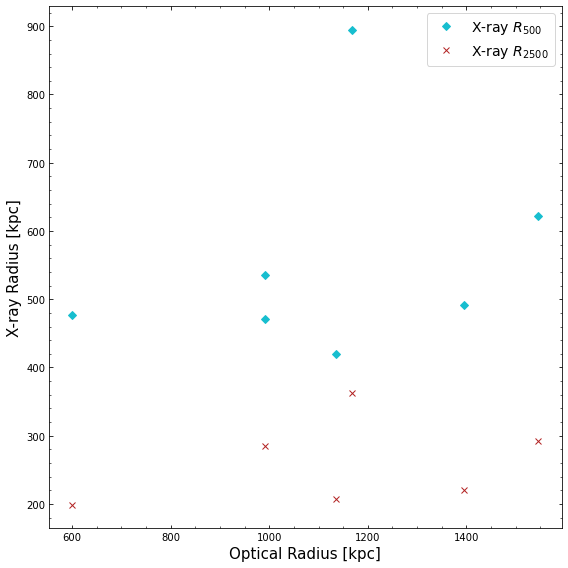

In [79]:
plt.figure(figsize=(8, 8))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(opt_r.value, r500.value, 'D', color='tab:cyan', label=r"X-ray $R_{500}$")
plt.plot(opt_r.value, r2500.value, 'x', color='firebrick', label=r"X-ray $R_{2500}$")

# plt.xlim(100, 1500)
# plt.ylim(100, 1000)

plt.xlabel("Optical Radius [kpc]", fontsize=15)
plt.ylabel("X-ray Radius [kpc]", fontsize=15)

# plt.xscale('log')
# plt.yscale('log')

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Measurements of impact parameter

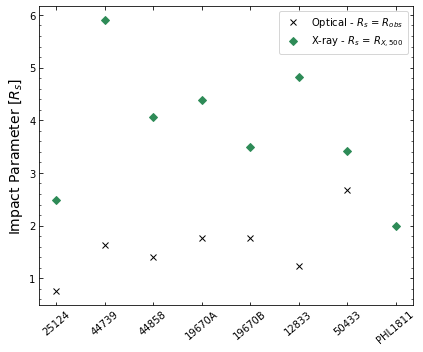

In [104]:
names = comb['name'].values

x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.plot(range(len(names)), opt_scale_imp_fac, 'x', label=r"Optical - $R_{s}$ = $R_{obs}$", 
         color='black')
plt.plot(range(len(names)), xr500_scale_imp_fac, 'D', label="X-ray - $R_{s}$ = $R_{X,500}$", 
         color='seagreen')
# plt.plot(range(len(names)), xr2500_scale_imp_fac, 'o', label="X-ray - $R_{s}$ = $R_{X,2500}$", 
#          color='goldenrod')

plt.ylabel(r"Impact Parameter [$R_{s}$]", fontsize=14)

plt.xticks(ticks=range(len(names)), labels=names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

# plt.savefig('../../outputs/figures/impact_factor_comp.pdf')
plt.show()

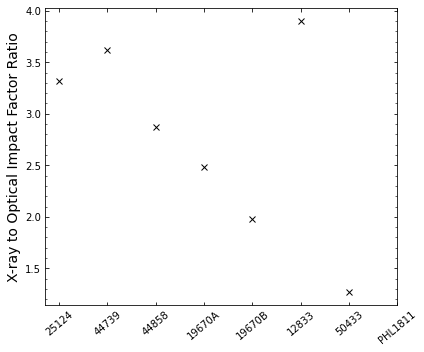

In [102]:
names = comb['name'].values

x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.plot(range(len(names)), xr500_scale_imp_fac / opt_scale_imp_fac, 'x', 
         color='black')


plt.ylabel(r"X-ray to Optical Impact Factor Ratio", fontsize=14)

plt.xticks(ticks=range(len(names)), labels=names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

# plt.legend()
plt.tight_layout()

# plt.savefig('../../outputs/figures/impact_factor_comp.pdf')
plt.show()